# **Drive mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import **Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import (LSTM, Dense, Embedding, SpatialDropout1D,
                          BatchNormalization, Bidirectional, GlobalMaxPool1D, Conv1D)
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import plotly as py
import cufflinks as cf
import tensorflow

# Data **Load**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/My_Research/Newspaper/Title_Classification/Dataset/NewspaperDataFinalVersion - Sports (1).csv")

In [ ]:
df

,Title,Paper Name,Category,Date
0,দিনজুড়ে বোলিংয়ে হতাশা,কালের কণ্ঠ,Sports,30 October 2024
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,কালের কণ্ঠ,Sports,30 October 2024
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,কালের কণ্ঠ,Sports,30 October 2024
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,কালের কণ্ঠ,Sports,30 October 2024
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,কালের কণ্ঠ,Sports,30 October 2024
...,...,...,...,...
6145,কাবরেরার ক্যাম্পে আরও ১১ জন,যুগান্তর,International,5 November 2024
6146,হলান্ডের প্রিয় খাবার কাঁচা মাছ!,যুগান্তর,International,5 November 2024
6147,কামিন্স ফিরেই জেতালেন অসিদের,যুগান্তর,International,5 November 2024
6148,পাকিস্তানও হারিয়ে দেবে ভারতকে',যুগান্তর,International,5 November 2024


In [ ]:
df.shape

(6150, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6150 entries, 0 to 6149
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       6150 non-null   object
 1   Paper Name  6150 non-null   object
 2   Category    6150 non-null   object
 3   Date        6150 non-null   object
dtypes: object(4)
memory usage: 192.3+ KB


In [ ]:
df.describe()

,Title,Paper Name,Category,Date
count,6150,6150,6150,6150
unique,6059,6,3,124
top,ভাঙ্গায় শিক্ষাবৃত্তি ও গুণী শিক্ষককে সংবর্ধনা ...,যুগান্তর,National,23 July 2023
freq,2,1770,2089,410


# Feature **Selection**

In [ ]:
df=df.drop(['Paper Name', 'Date'], axis=1)
df.head()

,Title,Category
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports


In [ ]:
old_column_name = 'Title Category'
new_column_name = 'Category'
df.rename(columns={'Title Category': 'Category'}, inplace=True)

In [ ]:
df

,Title,Category
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports
...,...,...
6145,কাবরেরার ক্যাম্পে আরও ১১ জন,International
6146,হলান্ডের প্রিয় খাবার কাঁচা মাছ!,International
6147,কামিন্স ফিরেই জেতালেন অসিদের,International
6148,পাকিস্তানও হারিয়ে দেবে ভারতকে',International


In [ ]:
df.columns=["Title","Category"]

In [ ]:
df.Category.value_counts()

,count
Category,
National,2089
International,2053
Sports,2008


# Data **Visualization**

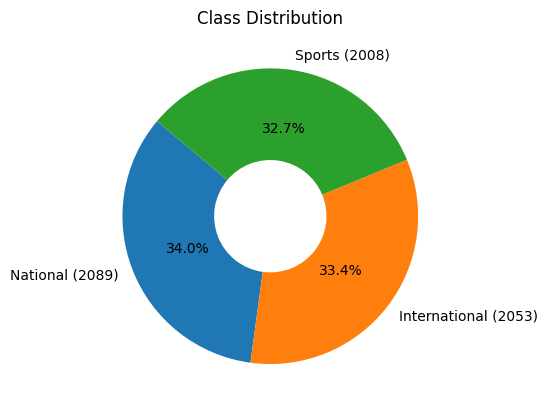

In [ ]:
# Calculate the counts and percentages
class_counts = df['Category'].value_counts()
class_percents = class_counts / class_counts.sum() * 100

# Create labels with both the percentage and the quantity
labels = [f'{category} ({count})' for category, count in zip(class_counts.index, class_counts)]

# Plot the donut chart
plt.pie(class_percents, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.62})
plt.title('Class Distribution')
plt.savefig("my_plot.png")
plt.show()

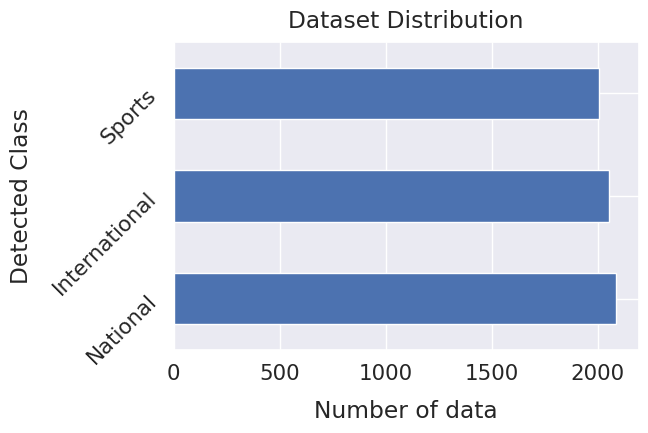

In [ ]:
sns.set(font_scale=1.4)
df['Category'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of data", labelpad=12)
plt.ylabel("Detected Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);
plt.savefig("Dataset Distribution BarChart.png")

# **Data Preperation and Preprocessing Step**

This Step Will Apply Over The Dataset
```
1. Convert Datatypes
2. Null Value Handle
3. Remove Dupliate Row
4. Remove Small Text
5. Remove Puncuatoion,Link,Emoji(No Character)
6. Remove Non bengali Character
7. Stopwords
8. Stemming
9. Sampling (Upper Samling and Downsampling)

```



**1. Convert Datatype**

In [ ]:
df['Title'] = df['Title'].astype(str)

df.to_csv('Title', index=False, encoding='utf-8')

In [ ]:
df.dtypes

,0
Title,object
Category,object


**2.Null Value Handle**

In [ ]:
df.isnull().sum()

,0
Title,0
Category,0


**3. Remove Dupliate Row**

Before Delete the duplicate row

In [ ]:
df.shape

(6150, 2)

In [ ]:
df.drop_duplicates(inplace=True)

After Delete the duplicate row

In [ ]:
df.shape

(6060, 2)

In [ ]:
df.head(30)

,Title,Category
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports
5,দুটি ম্যাচই নিষ্প্রাণ ড্র,Sports
6,রদ্রির মর্যাদার রাতে হতাশ ভিনিসিয়ুস,Sports
7,ছাদখোলা বাসের কথা মনে করিয়ে দিয়েছেন সানজিদা,Sports
8,পাকিস্তান টেস্টের কথা মনে করালেন সিমন্স,Sports
9,রদ্রির ব্যালন ডি'অর নিয়ে আলোচনা-সমালোচনা,Sports


**4. Remove Non-Character word**

In [ ]:
def remove_non_bengali_characters(Title):
    cleaned = re.sub(r'[^\u0980-\u09FF\s]+', ' ', Title)
    return cleaned.strip()

# Assuming df is your DataFrame and 'Title' is a column containing text data
df['Title'] = df['Title'].apply(remove_non_bengali_characters)

In [ ]:
df.head()

,Title,Category
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports


**5. Remove Non-Bengali Character**

In [ ]:
# Define a regular expression pattern to match Bengali characters and spaces
bengali_pattern = re.compile("[\u0980-\u09FF ]+")

# Function to remove non-Bengali characters from a string
def remove_non_bengali_chars(text):
    return "".join(filter(bengali_pattern.match, text))

# Apply the function to each element in your dataset
df['New_Title'] = df['Title'].apply(remove_non_bengali_chars)

In [ ]:
df.head(30)

,Title,Category,New_Title
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports,দিনজুড়ে বোলিংয়ে হতাশা
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports,ইস্টবেঙ্গলের কাছে বড় হার কিংসের
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports,মূল আলোচ্য নাজমুলের অধিনায়কত্ব
5,দুটি ম্যাচই নিষ্প্রাণ ড্র,Sports,দুটি ম্যাচই নিষ্প্রাণ ড্র
6,রদ্রির মর্যাদার রাতে হতাশ ভিনিসিয়ুস,Sports,রদ্রির মর্যাদার রাতে হতাশ ভিনিসিয়ুস
7,ছাদখোলা বাসের কথা মনে করিয়ে দিয়েছেন সানজিদা,Sports,ছাদখোলা বাসের কথা মনে করিয়ে দিয়েছেন সানজিদা
8,পাকিস্তান টেস্টের কথা মনে করালেন সিমন্স,Sports,পাকিস্তান টেস্টের কথা মনে করালেন সিমন্স
9,রদ্রির ব্যালন ডি অর নিয়ে আলোচনা সমালোচনা,Sports,রদ্রির ব্যালন ডি অর নিয়ে আলোচনা সমালোচনা


**6. Remove Stopwords**

In [ ]:
def process_conversations(Conversation):
    stp = open('/content/drive/MyDrive/My_Research/Newspaper/Title_Classification/Dataset/stopwords-bn.txt','r',encoding="utf8").read().split()
    result = Conversation.split()
    Conversation = [word.strip() for word in result if word not in stp ]
    Conversation =" ".join(Conversation)
    Conversation = re.sub('[^\u0980-\u09FF]',' ',str(Conversation))
    return Conversation

In [ ]:
df['cleaned'] = df['New_Title'].apply(process_conversations)
sample_data = [10,400]
for i in sample_data:
     print('Original:\n',df.New_Title[i],'\nCleaned:\n',
           df.cleaned[i],'\n','Detected as:-- ',df.Category[i],'\n')

Original:
 জর্জি স্টাবসের স্পিন খেলার মন্ত্র 
Cleaned:
 জর্জি স্টাবসের স্পিন খেলার মন্ত্র 
 Detected as:--  Sports 

Original:
 সৌদি আরবে বিশ্বকাপ হলে খুশি হবেন নেইমার 
Cleaned:
 সৌদি আরবে বিশ্বকাপ খুশি নেইমার 
 Detected as:--  Sports 



In [ ]:
df

,Title,Category,New_Title,cleaned
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports,দিনজুড়ে বোলিংয়ে হতাশা,দিনজুড়ে বোলিংয়ে হতাশা
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,ব্যাটিংয়ে চোখ সিমন্সের
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,ইস্টবেঙ্গলের বড় হার কিংসের
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,মূল আলোচ্য নাজমুলের অধিনায়কত্ব
...,...,...,...,...
6145,কাবরেরার ক্যাম্পে আরও ১১ জন,International,কাবরেরার ক্যাম্পে আরও ১১ জন,কাবরেরার ক্যাম্পে ১১
6146,হলান্ডের প্রিয় খাবার কাঁচা মাছ,International,হলান্ডের প্রিয় খাবার কাঁচা মাছ,হলান্ডের প্রিয় খাবার কাঁচা মাছ
6147,কামিন্স ফিরেই জেতালেন অসিদের,International,কামিন্স ফিরেই জেতালেন অসিদের,কামিন্স ফিরেই জেতালেন অসিদের
6148,পাকিস্তানও হারিয়ে দেবে ভারতকে,International,পাকিস্তানও হারিয়ে দেবে ভারতকে,পাকিস্তানও হারিয়ে দেবে ভারতকে


In [ ]:
df.drop(["Title","New_Title"],axis=1,inplace=True)

In [ ]:
df

,Category,cleaned
0,Sports,দিনজুড়ে বোলিংয়ে হতাশা
1,Sports,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা
2,Sports,ব্যাটিংয়ে চোখ সিমন্সের
3,Sports,ইস্টবেঙ্গলের বড় হার কিংসের
4,Sports,মূল আলোচ্য নাজমুলের অধিনায়কত্ব
...,...,...
6145,International,কাবরেরার ক্যাম্পে ১১
6146,International,হলান্ডের প্রিয় খাবার কাঁচা মাছ
6147,International,কামিন্স ফিরেই জেতালেন অসিদের
6148,International,পাকিস্তানও হারিয়ে দেবে ভারতকে


In [ ]:
df.columns=["Category","Title"]

In [ ]:
df.head(10)

,Category,Title
0,Sports,দিনজুড়ে বোলিংয়ে হতাশা
1,Sports,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা
2,Sports,ব্যাটিংয়ে চোখ সিমন্সের
3,Sports,ইস্টবেঙ্গলের বড় হার কিংসের
4,Sports,মূল আলোচ্য নাজমুলের অধিনায়কত্ব
5,Sports,ম্যাচই নিষ্প্রাণ ড্র
6,Sports,রদ্রির মর্যাদার রাতে হতাশ ভিনিসিয়ুস
7,Sports,ছাদখোলা বাসের কথা করিয়ে দিয়েছেন সানজিদা
8,Sports,পাকিস্তান টেস্টের কথা করালেন সিমন্স
9,Sports,রদ্রির ব্যালন ডি অর আলোচনা সমালোচনা


**7. Remove Small Text**

In [ ]:
df['no_char'] = df['Title'].apply(lambda Title: len(Title))

In [ ]:
df['length'] = df['Title'].apply(lambda x:len(x.split()))

In [ ]:
df = df.sort_values(by='length', ascending=False)

In [ ]:
df.head(100)

,Category,Title,no_char,length
2153,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,410,53
5686,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,223,32
4902,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,211,30
6014,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,231,29
4452,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,179,25
...,...,...,...,...
4759,National,শাহজালালে ২৫ কেজি স্বর্ণ উদ্ধার বিভাগীয় মামলা...,73,11
2462,National,বরিশাল সিটি করপোরেশন শিক্ষার্থী পরিচয়ে হয়রানির...,83,11
1569,International,দক্ষিণ আফ্রিকার কেপ টাউনে ট্যাক্সি ধর্মঘট বিক্...,75,11
2107,National,পরিকল্পনা উপদেষ্টা দুর্নীতি কিছুটা কমলেও চাঁদা...,80,11


In [ ]:
dataset = df.loc[df.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small conversations".format(len(df)-len(dataset)),
      "\nTotal conversations:",len(dataset))

After Cleaning: 
Removed 240 Small conversations 
Total conversations: 5820


In [ ]:
newdf = dataset.loc[dataset['length'] <= 100]
newdf = newdf.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Big conversations".format(len(dataset)-len(newdf)),
      "\nTotal conversations:",len(newdf))

After Cleaning: 
Removed 0 Big conversations 
Total conversations: 5820


In [ ]:
newdf.shape

(5820, 4)

In [ ]:
newdf.head()

,Category,Title,no_char,length
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,410,53
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,223,32
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,211,30
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,231,29
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,179,25


In [ ]:
newdf.drop(["no_char","length"],axis=1,inplace=True)

# **Stemming**

In [ ]:
import pandas as pd
from nltk.stem.lancaster import LancasterStemmer

# Assuming df is your existing DataFrame
# Instantiate Lancaster Stemmer (for comparison, but it won't be effective for Bangla)
lancaster_stemmer = LancasterStemmer()

def lancaster_stemming(text):
    return ' '.join([lancaster_stemmer.stem(word) for word in text.split()])

# Custom Bangla stemming function
suffixes = ['কে', 'য়ে', 'য়ে', 'য়', 'য়', 'য়']

def bangla_stemming(word):
    for suffix in suffixes:
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word

def custom_bangla_stemming(text):
    return ' '.join([bangla_stemming(word) for word in text.split()])

# Applying Lancaster Stemmer (for comparison)
newdf['LancasterStemming'] = newdf['Title'].apply(lancaster_stemming)

# Applying custom Bangla stemming function
newdf['BanglaStemming'] = newdf['Title'].apply(custom_bangla_stemming)

# Display the DataFrame
print(newdf[['Title', 'LancasterStemming', 'BanglaStemming']])

                                                  Title  \
0     পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...   
1     পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...   
2     ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...   
3     খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...   
4     তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...   
...                                                 ...   
5815                                  ঘুম ভাঙছে বাফুফের   
5816                                     মেসির জোড়া গোল   
5817                         এমবাপ্পের রিয়ালের অপেক্ষা   
5818                                ফিরমিনো সৌদি ক্লাবে   
5819                         সপ্তাহেই অন্তর্বর্তী কমিটি   

                                      LancasterStemming  \
0     পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...   
1     পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...   
2     ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...   
3     খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...

In [ ]:
from nltk.stem import LancasterStemmer, PorterStemmer
import pandas as pd

# Instantiate stemmers
lancaster_stemmer = LancasterStemmer()
# Define stemming functions
def lancaster_stemming(text):
    return ' '.join([lancaster_stemmer.stem(word) for word in text.split()])

newdf['LancasterStemming'] = newdf['Title'].apply(lancaster_stemming)

In [ ]:
newdf

,Category,Title,LancasterStemming,BanglaStemming
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...
...,...,...,...,...
5815,Sports,ঘুম ভাঙছে বাফুফের,ঘুম ভাঙছে বাফুফের,ঘুম ভাঙছে বাফুফের
5816,Sports,মেসির জোড়া গোল,মেসির জোড়া গোল,মেসির জোড়া গোল
5817,Sports,এমবাপ্পের রিয়ালের অপেক্ষা,এমবাপ্পের রিয়ালের অপেক্ষা,এমবাপ্পের রিয়ালের অপেক্ষা
5818,Sports,ফিরমিনো সৌদি ক্লাবে,ফিরমিনো সৌদি ক্লাবে,ফিরমিনো সৌদি ক্লাবে


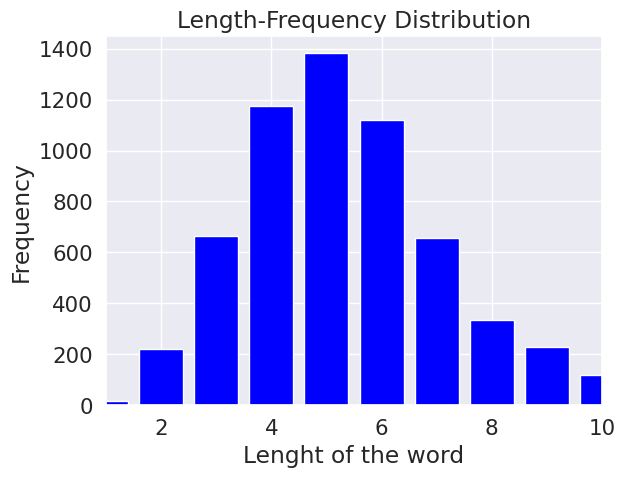

Maximum Length of a sentence: 53
Minimum Length of a sentence: 0
Average Length of a sentence: 5.0


<Figure size 640x480 with 0 Axes>

In [ ]:
frequency = dict()
for i in df.length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 10)

plt.xlabel('Lenght of the word')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a sentence: {max(df.length)}")
print(f"Minimum Length of a sentence: {min(df.length)}")
print(f"Average Length of a sentence: {round(np.mean(df.length),0)}")

plt.savefig("Length-Frequency Distribution Bangla BarChart.png")

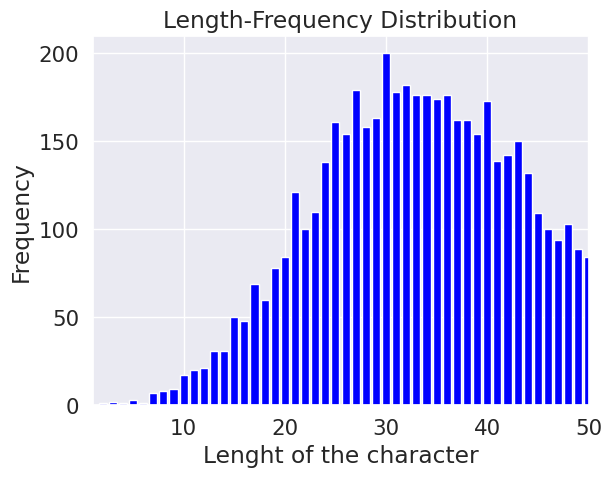

Maximum Length of a sentence: 410
Minimum Length of a sentence: 0
Average Length of a sentence: 39.0


<Figure size 640x480 with 0 Axes>

In [ ]:
frequency = dict()
for i in df.no_char:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="blue")
plt.xlim(1, 50)

plt.xlabel('Lenght of the character')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
print(f"Maximum Length of a sentence: {max(df.no_char)}")
print(f"Minimum Length of a sentence: {min(df.no_char)}")
print(f"Average Length of a sentence: {round(np.mean(df.no_char),0)}")
plt.savefig("Character Frequency Distribution Bangla BarChart.png")

In [ ]:
pip install wordcloud matplotlib

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def data_summary(df, font_path):
    documents = []
    words = []
    most_frequent_word = []
    u_words = []

    total_u_words = [word.strip().lower() for t in list(df.Title) for word in t.strip().split()]
    class_label = [k for k, v in df.Category.value_counts().to_dict().items()]

    for label in class_label:
        word_list = [word.strip().lower() for t in list(df[df.Category == label].Title) for word in t.strip().split()]

        counts = dict()

        for word in word_list:
            counts[word] = counts.get(word, 0) + 1

        ordered = sorted(counts.items(), key=lambda item: item[1], reverse=True)

        documents.append(len(list(df[df.Category == label].Title)))
        words.append(len(word_list))
        u_words.append(len(np.unique(word_list)))

        print("\nClass Name : ", label)
        print("Number of sentences: {}".format(len(list(df[df.Category == label].Title))))
        print("Number of Words: {}".format(len(word_list)))
        print("Number of Unique Words: {}".format(len(np.unique(word_list))))
        print("Most Frequent Words:\n")
        for k, v in ordered[:15]:
            print("{}\t{}".format(k, v))

        # Generate and display the word cloud with specified font
        wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(counts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {label}")
        plt.axis('off')
        plt.show()

    print("Total Number of Unique Words: {}".format(len(np.unique(total_u_words))))

    return documents, words, u_words, class_label


Class Name :  National
Number of sentences: 2056
Number of Words: 12964
Number of Unique Words: 5751
Most Frequent Words:

মৃত্যু	71
হত্যা	61
টাকা	60
গ্রেফতার	54
দাবি	54
নিহত	47
মামলা	44
ডেঙ্গু	41
উদ্ধার	41
সাবেক	39
তিন	39
দাবিতে	38
বিরুদ্ধে	37
ব্যাংকের	35
লাশ	34


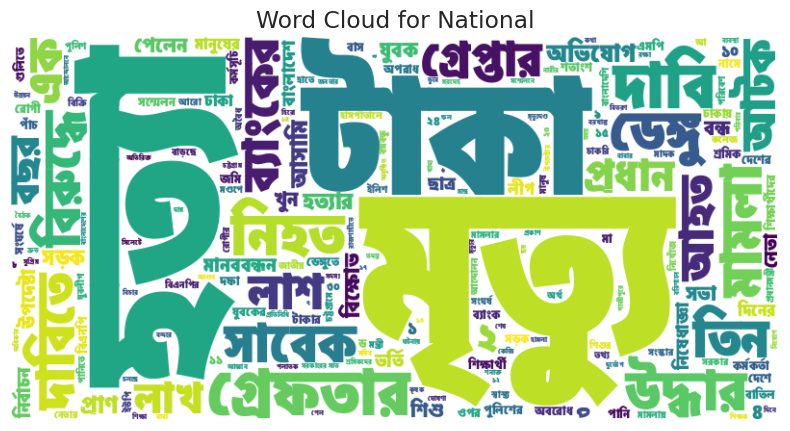


Class Name :  International
Number of sentences: 2015
Number of Words: 11838
Number of Unique Words: 4765
Most Frequent Words:

নিহত	138
হামলা	59
মৃত্যু	52
মার্কিন	46
রুশ	44
বিরুদ্ধে	42
চীন	41
চীনের	41
সেনা	39
বছরের	37
বছর	37
ড্রোন	35
মণিপুরে	35
ভারত	35
ইউক্রেন	34


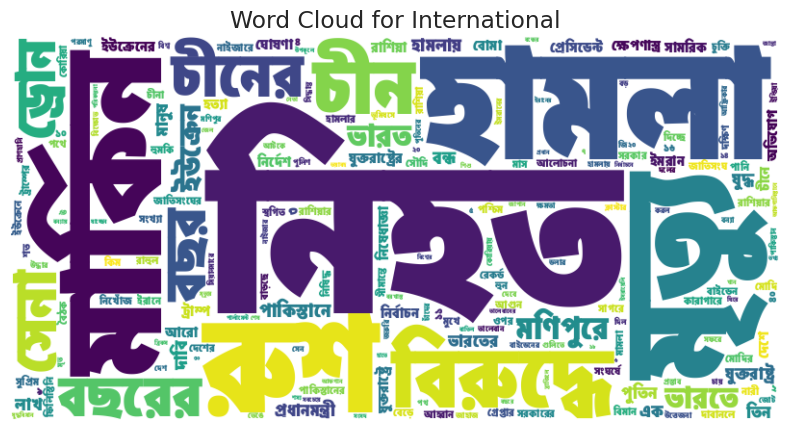


Class Name :  Sports
Number of sentences: 1989
Number of Words: 8379
Number of Unique Words: 3788
Most Frequent Words:

বাংলাদেশ	84
বাংলাদেশের	62
জয়	57
ভারত	56
ম্যাচ	41
শেষ	37
সাকিব	36
হার	34
জয়	34
ভারতের	33
দল	32
সাকিবের	31
ফুটবল	30
বিশ্বকাপ	30
সেঞ্চুরি	28


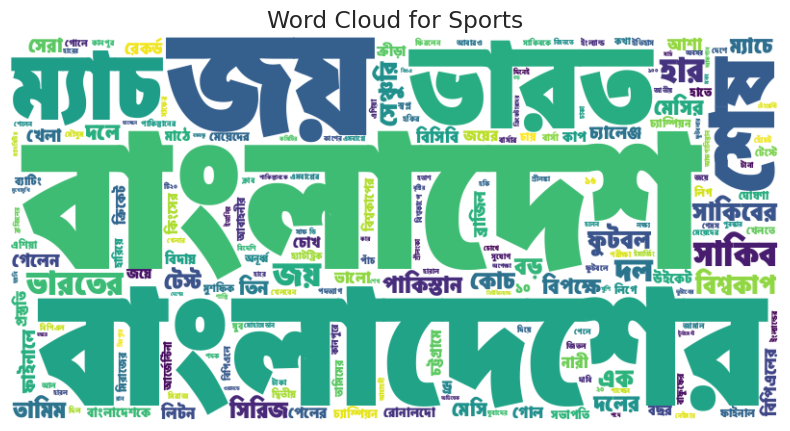

Total Number of Unique Words: 11504


In [ ]:
# Assuming df is your dataframe and specifying the path to a Bangla-compatible font
font_path = '/content/drive/MyDrive/My_Research/Newspaper/Title_Classification/static/NotoSansBengali_ExtraCondensed-Black.ttf'  # Update this with the actual path to your Bangla font
documents, words, u_words, class_names = data_summary(df, font_path)

In [ ]:
data_matrix = pd.DataFrame({'Total Sentences':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
data = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")

In [ ]:
data

,Class Names,Category,Values
0,National,Total Sentences,2056
1,International,Total Sentences,2015
2,Sports,Total Sentences,1989
3,National,Total Words,12964
4,International,Total Words,11838
5,Sports,Total Words,8379
6,National,Unique Words,5751
7,International,Unique Words,4765
8,Sports,Unique Words,3788


<ipython-input-55-8fafc97404a3>:8: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



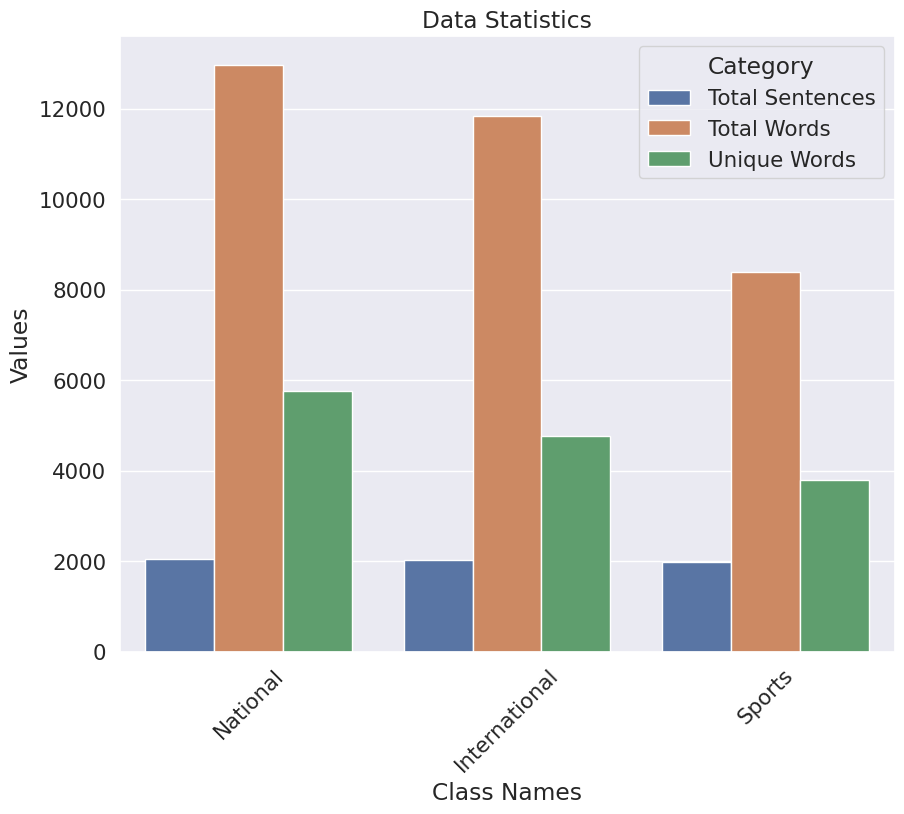

In [ ]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()

sns.barplot(data=data,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names')
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

plt.savefig("Data Statistics Bangla BarChart.png")

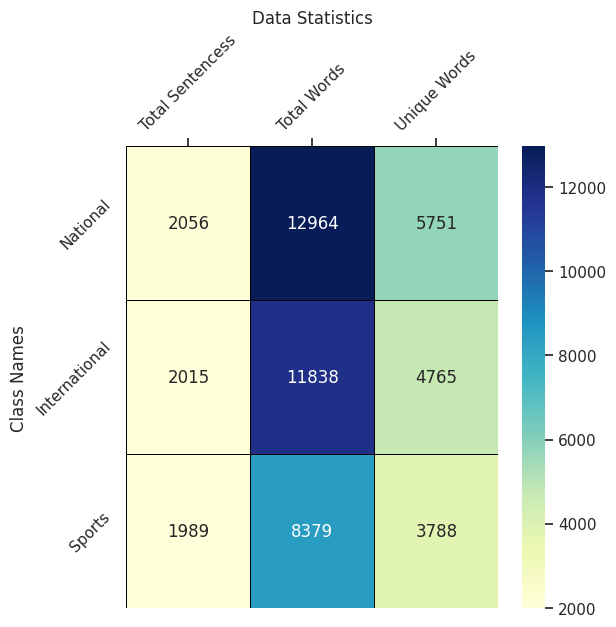

In [ ]:
sns.set()
plt.figure(figsize =(6, 6))
ax = plt.subplot()
sns.heatmap(data_matrix.iloc[:,0:3], annot=True,fmt="d", linewidths=0.5,linecolor = 'Black',cmap = "YlGnBu",ax = ax)

ax.set_ylabel('Class Names')
ax.set_title('Data Statistics')
y_label = ["Total Sentencess", "Total Words", "Unique Words"]
ax.xaxis.set_ticklabels(y_label, rotation=45); ax.yaxis.set_ticklabels(class_names, rotation=45);
ax.xaxis.tick_top()
plt.savefig("Data Statistics Bangla.png")

In [ ]:
newdf.cleaned = newdf.LancasterStemming.apply(lambda x:x.replace('\n',' '))

<ipython-input-57-49d0fdc40270>:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [ ]:
newdf

,Category,Title,LancasterStemming,BanglaStemming
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...
...,...,...,...,...
5815,Sports,ঘুম ভাঙছে বাফুফের,ঘুম ভাঙছে বাফুফের,ঘুম ভাঙছে বাফুফের
5816,Sports,মেসির জোড়া গোল,মেসির জোড়া গোল,মেসির জোড়া গোল
5817,Sports,এমবাপ্পের রিয়ালের অপেক্ষা,এমবাপ্পের রিয়ালের অপেক্ষা,এমবাপ্পের রিয়ালের অপেক্ষা
5818,Sports,ফিরমিনো সৌদি ক্লাবে,ফিরমিনো সৌদি ক্লাবে,ফিরমিনো সৌদি ক্লাবে


In [ ]:
newdf=newdf.drop(["Title","LancasterStemming"],axis=1)

In [ ]:
newdf

,Category,BanglaStemming
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...
...,...,...
5815,Sports,ঘুম ভাঙছে বাফুফের
5816,Sports,মেসির জোড়া গোল
5817,Sports,এমবাপ্পের রিয়ালের অপেক্ষা
5818,Sports,ফিরমিনো সৌদি ক্লাবে


In [ ]:
newdf.rename(columns={'BanglaStemming': 'cleaned'}, inplace=True)

In [ ]:
newdf.head()

,Category,cleaned
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...


# **Unigram Tf-idf value calculation**

In [ ]:
def calc_gram_tfidf(Conversations):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split())
    X = tfidf.fit_transform(Conversations)

    return tfidf,X

In [ ]:
#unigram
x = ["তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চীন"]

def get_top_n_words(x, n):
    vec = CountVectorizer().fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]

get_top_n_words(x,3)

[('ইওয', 1), ('মহড', 1), ('ডজন', 1)]

In [ ]:
#bigram
y = ["তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চীন"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(y,3)

[('ইওয মহড', 1), ('মহড ডজন', 1), ('ডজন ধব', 1)]

In [ ]:
#trigram
z = ["তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চীন"]
def get_top_n_words(x, n):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(x)
    bow = vec.transform(x)
    sum_words = bow.sum(axis = 0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq[:n]
get_top_n_words(z,3)

[('ইওয মহড ডজন', 1), ('মহড ডজন ধব', 1)]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **Tokenization**

In [ ]:
newdf

,Category,cleaned
0,National,পল্লী বিদ্যুতে অস্থিরতাবিদ্যুত্ সরবরাহ বন্ধের ...
1,International,পুতিন কিম বৈঠকের ক্ষেপণাস্ত্র ছুড়ল উ কোরিয়াদক্...
2,Sports,ছুটিতে যাওয়ার দাবিদাওয়া জানিয়ে গেছেন সাবিনারাব...
3,International,খমুতে রুশ ব্রিগেডের বিরুদ্ধে সাফল্যের দাবি ইউক...
4,International,তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চী...
...,...,...
5815,Sports,ঘুম ভাঙছে বাফুফের
5816,Sports,মেসির জোড়া গোল
5817,Sports,এমবাপ্পের রিয়ালের অপেক্ষা
5818,Sports,ফিরমিনো সৌদি ক্লাবে


In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)  # Set max vocab size
tokenizer.fit_on_texts(newdf['cleaned'].values)
X = tokenizer.texts_to_sequences(newdf['cleaned'].values)

# Pad sequences to a fixed length
max_len = 100  # Adjust according to your dataset
X = pad_sequences(X, maxlen=max_len)

# One-hot encode the labels
Y = pd.get_dummies(newdf['Category']).values

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verify the shape of the data
print("X_train shape:", X_train.shape)  # Should be (num_samples, max_len)
print("Y_train shape:", Y_train.shape)  # Should be (num_samples, num_classes)
print("X_val shape:", X_val.shape)      # Should be (num_samples, max_len)
print("Y_val shape:", Y_val.shape)      # Should be (num_samples, num_classes)

X_train shape: (4656, 100)
Y_train shape: (4656, 3)
X_val shape: (1164, 100)
Y_val shape: (1164, 3)


In [ ]:
# Assuming you have already created the 'tokenizer' object
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token (index 0)

print("Vocabulary size:", vocab_size)

Vocabulary size: 11008


In [ ]:
# Check if X_train is a 2D array
assert len(X_train.shape) == 2, "X_train should be a 2D array"

In [ ]:
# Assume X_train is your training data with shape (num_samples, max_len)
input_shape = X_train.shape

In [ ]:
vocab_size = 11008  # Replace with the actual size of your vocabulary
embedding_dim = 300  # Replace with your desired embedding dimension

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[1])

In [ ]:
from tensorflow.keras.regularizers import l2

# Define the model
embed_dim = 64  # Size of the embedding vectors

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=embed_dim, input_length=max_len))  # Correct input_length
model.add(SpatialDropout1D(0.4))  # Dropout layer to reduce overfitting
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.4, kernel_regularizer=l2(0.01)))  # LSTM layer # Added l2 regularizer
model.add(BatchNormalization())  # Batch normalization
model.add(Dense(Y_train.shape[1], activation='softmax'))  # Output layer for the number of classes

# Compile the model
optimizer = Adam(learning_rate=0.0003)  # Slightly reduced learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping with patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=15,  # Increase number of epochs with patience
                    batch_size=64,
                    callbacks=[early_stopping])

# After training, evaluate the model on validation data
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_acc}")

Epoch 1/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.4025 - loss: 1.9787 - val_accuracy: 0.6091 - val_loss: 1.7299
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5630 - loss: 1.5388 - val_accuracy: 0.6186 - val_loss: 1.5526
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.7056 - loss: 1.1995 - val_accuracy: 0.6581 - val_loss: 1.3994
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.8069 - loss: 0.9362 - val_accuracy: 0.7620 - val_loss: 1.2427
Epoch 5/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8620 - loss: 0.7154 - val_accuracy: 0.7964 - val_loss: 1.0749
Epoch 6/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9056 - loss: 0.5547 - val_accuracy: 0.8385 - val_loss: 0.8841
Epoch 7/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9141 - loss: 0.4648 - val_accuracy: 0.8479 - val_loss: 0.7167
Epoch 8/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.9375 - loss: 0.3830 - val_accuracy: 0.8385 - 

In [ ]:
import tensorflow as tf

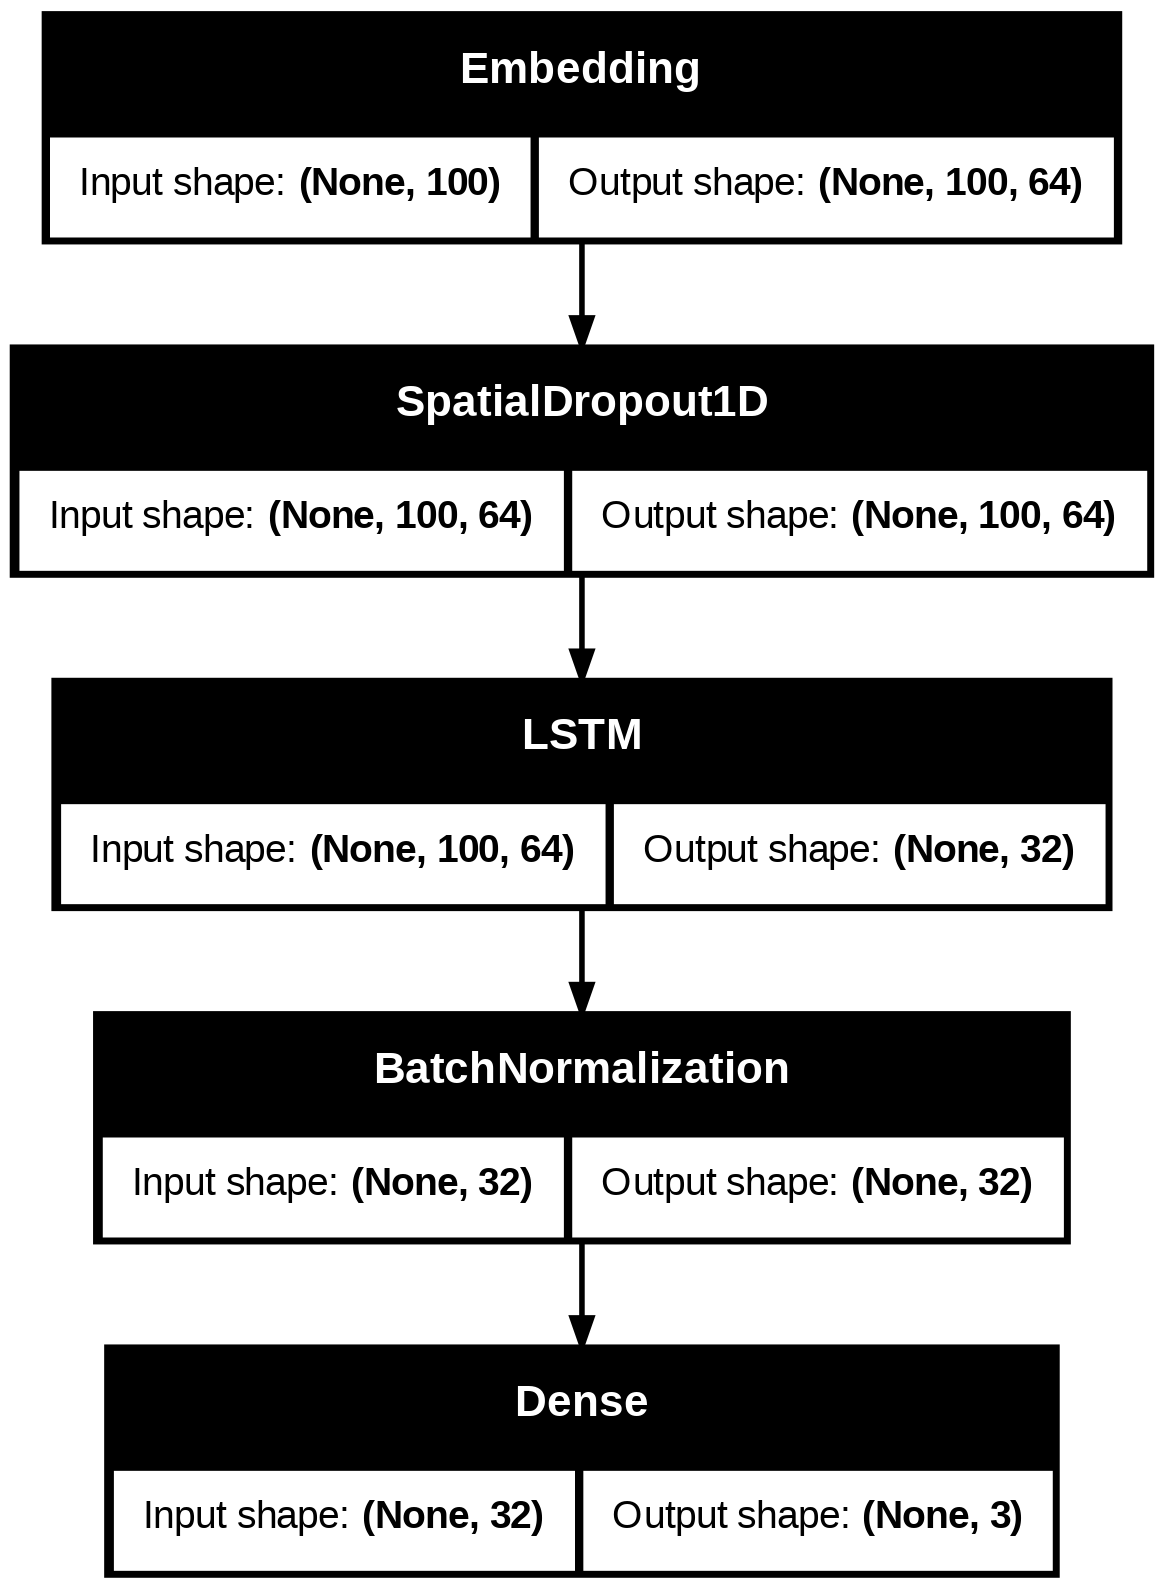

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-9gj41c1v
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-9gj41c1v
  Resolved https://github.com/paulgavrikov/visualkeras to commit 3cb339c3fbd7e96f9764a4c1d0966fd403510f3b
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 12.4 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.1.3-py3-none-any.whl size=16304 sha256=84b9198894c55f785e80ef775266ec3f0993d5cae6d3b7f018a87b8e411b3cc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-31j5dpbp/wheels/89/d3/c2/937382b33c09192fc84331bbc02c4565d62aeae67e9684c37e
Successfully built visualkeras


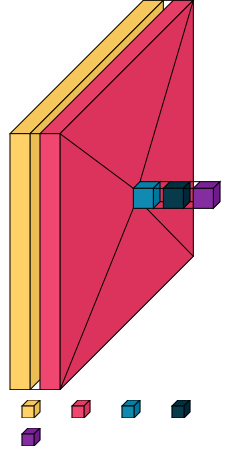

In [ ]:
from tensorflow.keras.models import Model
!pip install git+https://github.com/paulgavrikov/visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True)

# **Evaluation**

In [ ]:
score = model.evaluate(X_train, Y_train,batch_size=64, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

73/73 - 2s - 26ms/step - accuracy: 0.9931 - loss: 0.1553
Train loss: 0.1553250402212143
Train accuracy: 0.993127167224884


In [ ]:
score = model.evaluate(X_val, Y_val,batch_size=64, verbose=2)
print('Test loss:', score[0])
acc=score[1]
print('Test accuracy:', acc)

19/19 - 1s - 30ms/step - accuracy: 0.8625 - loss: 0.5136
Test loss: 0.5136062502861023
Test accuracy: 0.8625429272651672


# **Learning Curve**

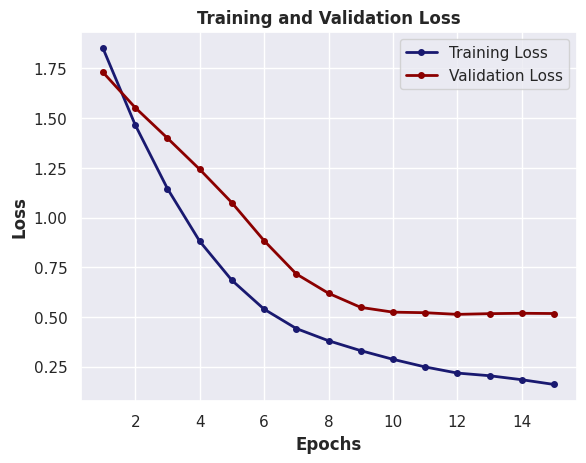

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, loss_values, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Loss')
plt.plot(epochs, val_loss_values, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

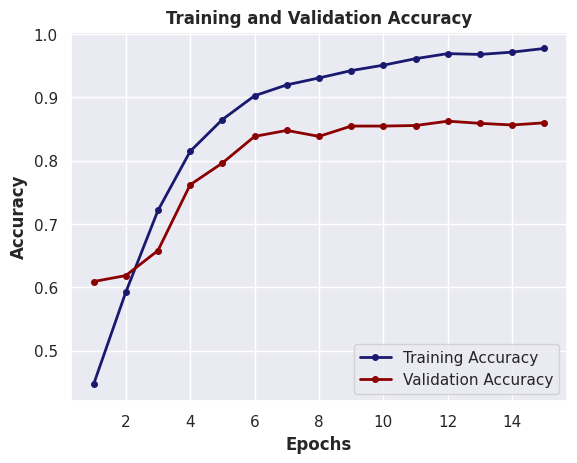

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
sns.set_style('darkgrid')

plt.plot(epochs, acc, color='midnightblue', linewidth=2,
          marker='o', markersize=4, label='Training Accuracy')
plt.plot(epochs, val_acc, color='darkred', linewidth=2,
          marker='o', markersize=4, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


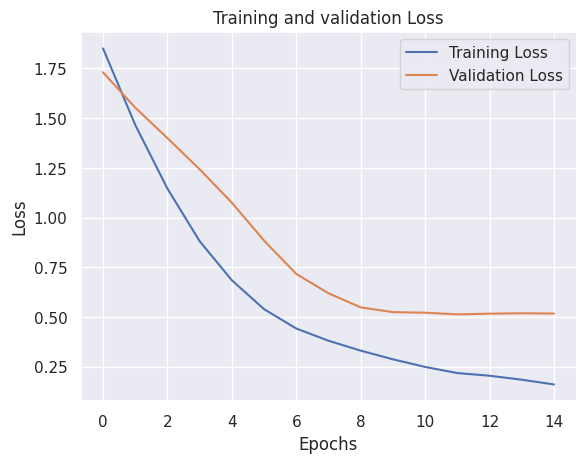

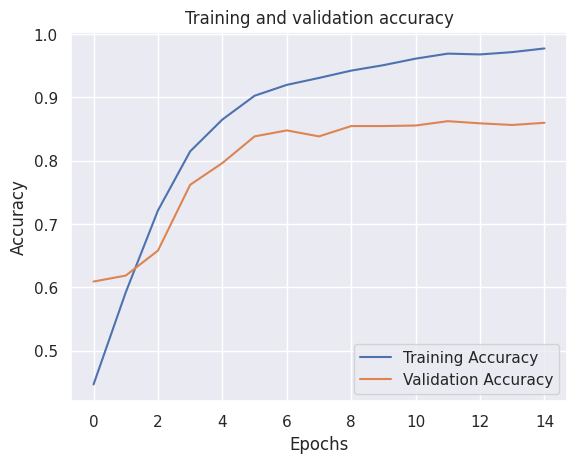

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

# **Confusion Matrix & Classification Report**

In [ ]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((4656, 100), (4656, 3), (1164, 100), (1164, 3))

In [ ]:
y_pred=model.predict(X_val)
y_pred=np.argmax(y_pred, axis=1)
y_val=np.argmax(Y_val, axis=1)
cm = confusion_matrix(y_val, y_pred)
print(cm)

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
[[334  45  20]
 [ 43 353  21]
 [ 11  20 317]]


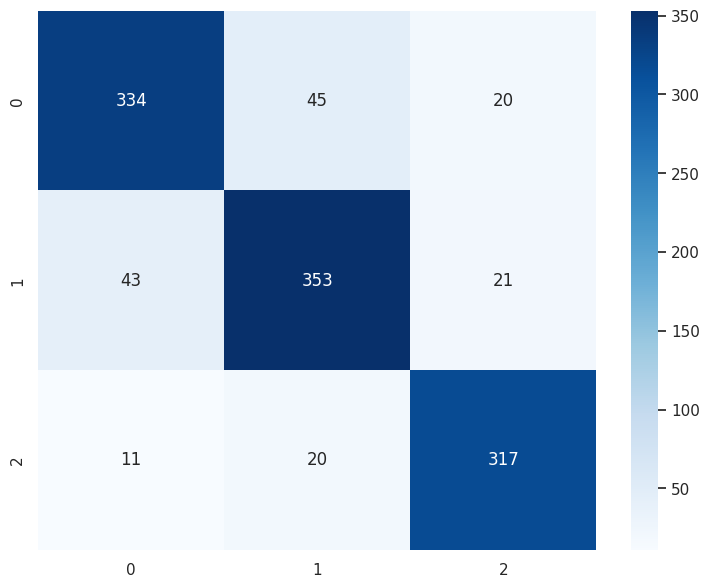

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cm,cmap='Blues', annot=True,fmt='d')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = pd.DataFrame(classification_report(y_val, y_pred,output_dict=True)).transpose()

In [ ]:
report = report.rename(index={'0': 'International','1': 'National','2': 'Sports'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))

In [ ]:
report

,precision,recall,f1-score,support
International,86.08,83.71,84.88,399.000000
National,84.45,84.65,84.55,417.000000
Sports,88.55,91.09,89.80,348.000000
accuracy,86.25,86.25,86.25,0.862543
macro avg,86.36,86.48,86.41,1164.000000
weighted avg,86.23,86.25,86.23,1164.000000


In [ ]:
twt = ['তাইওয়ানের মহড়া ঘিরে ডজন যুদ্ধবিমান পাঠালো চীন']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
print(twt)
Category = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(Category) == 0):
    print("International")
elif (np.argmax(Category) == 1):
    print("National")
else:
    print("Sports")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 2013  627  377 2855  547 2856   20]]
1/1 - 0s - 250ms/step
International


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(newdf['cleaned'], newdf['Category'], test_size=0.2, random_state=42)

In [ ]:
X_val.shape

(1164,)

In [ ]:
y_val.shape,y_pred.shape

((1164,), (1164,))

In [ ]:
import pandas as pd
import numpy as np

# Create an empty dataframe
df = pd.DataFrame()

# Set the Title in the dataframe
df['Title'] = X_val

# Add the actual Category and predicted Category columns if available
df['Actual Category'] = y_val

# Print unique values in y_pred
unique_values = np.unique(y_pred)
print("Unique Values in y_pred:", unique_values)

# Replace values in the Predicted Category column
df['Predicted Category'] = np.where(y_pred == unique_values[0], 'International',
                                     np.where(y_pred == unique_values[1], 'National', 'Sports'))

# Add the predicted percentage column based on the match between actual and predicted categories
df['Predicted Percentage'] = np.where(df['Actual Category'] == df['Predicted Category'], 100, 0)

Unique Values in y_pred: [0 1 2]


In [ ]:
df.tail(30)

,Title,Actual Category,Predicted Category,Predicted Percentage
4458,প্রশ্নফাঁসবুয়েট শিক্ষকসহ ১৬ বিচার,National,National,100
1168,ডেঙ্গুতে চারজনের মৃত্যু অর্ধেকের রোগী ঢাকার বাইরে,National,National,100
73,তিন পার্বত্য জেলায় ২৪ ভ্রমণ পরামর্শ পাহাড়ে কঠি...,National,National,100
4955,হাতিরঝিলে ভাসছিল যুবকের লাশ,National,National,100
4216,শূন্যের বিব্রতকর রেকর্ড জাকিরের,Sports,Sports,100
2441,মিয়ানমারের যুদ্ধবিমানে জ্বালানি সরবরাহে নিষেধা...,International,International,100
2780,বনানীতে বাসের ধাক্কা নারী নিহত,National,International,0
1888,চিকিৎসা শেষে ফেরার পথে প্রাণ বৃদ্ধার,National,National,100
1319,ভারত শ্রীলঙ্কা খাদ্য মূল্যস্ফীতি কমলেও বেড়েছে...,National,National,100
3107,কারাগারে ৫০০ বন্দির অনশন ধর্মঘট,International,National,0
